In [9]:
import zipfile
import os
zip_file_path = 'cashflow_data.zip'
extract_path = os.path.dirname(zip_file_path)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(zip_file_path))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil

consumers = pd.read_parquet("cashflow/consumer_data.parquet")
transactions = pd.read_parquet('cashflow/transactions.parquet')
categories = pd.read_csv('transaction_categories.csv')

#after import to the file, we can delete the unzip folder. 
shutil.rmtree('cashflow')

In [11]:
consumers

,evaluation_date,FPF_TARGET,total_balance,masked_consumer_id
0,2021-08-26,0.0,1380.84,C01100001
1,2022-08-02,0.0,20163.90,C01100002
2,2021-03-04,0.0,3986.25,C01100003
3,2022-11-19,0.0,5956.03,C01100004
4,2021-11-21,0.0,29421.10,C01100005
...,...,...,...,...
4995,2023-03-31,0.0,1412.80,C04104996
4996,2023-03-31,0.0,-439.21,C04104997
4997,2023-03-31,0.0,84.53,C04104998
4998,2023-03-31,0.0,52655.88,C04104999


In [12]:
# Merging dataframes
transactions = pd.merge(transactions, categories, left_on='category', right_on='code', how='left')
merged_df = pd.merge(transactions, consumers, left_on='masked_consumer_id', right_on='masked_consumer_id', how='left')

# Display the first few rows of the merged dataframe
merged_df.head()

,masked_consumer_id,posted_date,amount,category,masked_transaction_id,code,description,evaluation_date,FPF_TARGET,total_balance
0,C02103629,2022-08-12,-21.00,27.0,C02T02715977,27.0,HEALTHCARE_MEDICAL,2022-11-16,1.0,109.53
1,C02103629,2022-08-09,-8.60,22.0,C02T02715978,22.0,ESSENTIAL_SERVICES,2022-11-16,1.0,109.53
2,C02103629,2022-08-07,-30.05,16.0,C02T02715979,16.0,GENERAL_MERCHANDISE,2022-11-16,1.0,109.53
3,C02103629,2022-09-29,-0.46,0.0,C02T02715980,0.0,SELF_TRANSFER,2022-11-16,1.0,109.53
4,C02103629,2022-07-21,-50.00,12.0,C02T02715981,12.0,LOAN,2022-11-16,1.0,109.53


In [13]:
merged_df.shape

(17738083, 10)

In [14]:
for col in merged_df.select_dtypes(include=['float64']).columns:
    merged_df[col] = merged_df[col].astype('float32')

In [15]:
# target label, 1 for default
merged_df['FPF_TARGET'].value_counts()

0.0    15751353
1.0     1986730
Name: FPF_TARGET, dtype: int64

In [16]:
merged_df['ClientID'] = merged_df['masked_consumer_id'].str[:3]

# Map ClientID to product type
client_product_map = {
    'C01': 'Personal Loans',
    'C02': 'Payday Loans',
    'C03': 'Credit Cards',
    'C04': 'Personal Loans'
}

merged_df['Product'] = merged_df['ClientID'].map(client_product_map)

In [17]:
merged_df

,masked_consumer_id,posted_date,amount,category,masked_transaction_id,code,description,evaluation_date,FPF_TARGET,total_balance,ClientID,Product
0,C02103629,2022-08-12,-21.000000,27.0,C02T02715977,27.0,HEALTHCARE_MEDICAL,2022-11-16,1.0,109.529999,C02,Payday Loans
1,C02103629,2022-08-09,-8.600000,22.0,C02T02715978,22.0,ESSENTIAL_SERVICES,2022-11-16,1.0,109.529999,C02,Payday Loans
2,C02103629,2022-08-07,-30.049999,16.0,C02T02715979,16.0,GENERAL_MERCHANDISE,2022-11-16,1.0,109.529999,C02,Payday Loans
3,C02103629,2022-09-29,-0.460000,0.0,C02T02715980,0.0,SELF_TRANSFER,2022-11-16,1.0,109.529999,C02,Payday Loans
4,C02103629,2022-07-21,-50.000000,12.0,C02T02715981,12.0,LOAN,2022-11-16,1.0,109.529999,C02,Payday Loans
...,...,...,...,...,...,...,...,...,...,...,...,...
17738078,C04100784,2021-05-24,-84.959999,22.0,C04T01072780,22.0,ESSENTIAL_SERVICES,2022-03-31,1.0,2212.179932,C04,Personal Loans
17738079,C04100784,2021-05-24,-25.000000,15.0,C04T01072781,15.0,UNCATEGORIZED,2022-03-31,1.0,2212.179932,C04,Personal Loans
17738080,C04100784,2021-05-26,-1.000000,1.0,C04T01072782,1.0,EXTERNAL_TRANSFER,2022-03-31,1.0,2212.179932,C04,Personal Loans
17738081,C04100784,2021-05-26,-5.000000,1.0,C04T01072783,1.0,EXTERNAL_TRANSFER,2022-03-31,1.0,2212.179932,C04,Personal Loans


In [18]:
merged_df = merged_df.drop(columns=['ClientID', 'masked_transaction_id', 'code', 'description'])
merged_df.head()


,masked_consumer_id,posted_date,amount,category,evaluation_date,FPF_TARGET,total_balance,Product
0,C02103629,2022-08-12,-21.000000,27.0,2022-11-16,1.0,109.529999,Payday Loans
1,C02103629,2022-08-09,-8.600000,22.0,2022-11-16,1.0,109.529999,Payday Loans
2,C02103629,2022-08-07,-30.049999,16.0,2022-11-16,1.0,109.529999,Payday Loans
3,C02103629,2022-09-29,-0.460000,0.0,2022-11-16,1.0,109.529999,Payday Loans
4,C02103629,2022-07-21,-50.000000,12.0,2022-11-16,1.0,109.529999,Payday Loans


In [19]:
merged_df['posted_date'] = pd.to_datetime(merged_df['posted_date'])
merged_df['posted_year'] = merged_df['posted_date'].dt.year
merged_df

,masked_consumer_id,posted_date,amount,category,evaluation_date,FPF_TARGET,total_balance,Product,posted_year
0,C02103629,2022-08-12,-21.000000,27.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
1,C02103629,2022-08-09,-8.600000,22.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
2,C02103629,2022-08-07,-30.049999,16.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
3,C02103629,2022-09-29,-0.460000,0.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
4,C02103629,2022-07-21,-50.000000,12.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
...,...,...,...,...,...,...,...,...,...
17738078,C04100784,2021-05-24,-84.959999,22.0,2022-03-31,1.0,2212.179932,Personal Loans,2021.0
17738079,C04100784,2021-05-24,-25.000000,15.0,2022-03-31,1.0,2212.179932,Personal Loans,2021.0
17738080,C04100784,2021-05-26,-1.000000,1.0,2022-03-31,1.0,2212.179932,Personal Loans,2021.0
17738081,C04100784,2021-05-26,-5.000000,1.0,2022-03-31,1.0,2212.179932,Personal Loans,2021.0


In [20]:
transactions[transactions['amount'] > 0].groupby("description").mean()

,amount,category,code
description,,,
DEPOSIT,1040.600877,2.0,2.0
EXTERNAL_TRANSFER,482.042978,1.0,1.0
INSURANCE,1178.782752,13.0,13.0
INVESTMENT_INCOME,398.421503,7.0,7.0
LOAN,1665.957308,12.0,12.0
MISCELLANEOUS,854.477960,4.0,4.0
OTHER_BENEFITS,1471.051182,8.0,8.0
PAYCHECK,1530.193763,3.0,3.0
PAYCHECK_PLACEHOLDER,1306.227283,5.0,5.0


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17738083 entries, 0 to 17738082
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   masked_consumer_id  object        
 1   posted_date         datetime64[ns]
 2   amount              float32       
 3   category            float32       
 4   evaluation_date     object        
 5   FPF_TARGET          float32       
 6   total_balance       float32       
 7   Product             object        
 8   posted_year         float64       
dtypes: datetime64[ns](1), float32(4), float64(1), object(3)
memory usage: 1.1+ GB


In [22]:
categories.head()

,code,description
0,0,SELF_TRANSFER
1,1,EXTERNAL_TRANSFER
2,2,DEPOSIT
3,3,PAYCHECK
4,4,MISCELLANEOUS


In [23]:
category_mapping = dict()
for row in categories.iterrows():
    category_mapping[row[1]['code']] = row[1]['description']
category_mapping

{0: 'SELF_TRANSFER',
 1: 'EXTERNAL_TRANSFER',
 2: 'DEPOSIT',
 3: 'PAYCHECK',
 4: 'MISCELLANEOUS',
 5: 'PAYCHECK_PLACEHOLDER',
 6: 'REFUND',
 7: 'INVESTMENT_INCOME',
 8: 'OTHER_BENEFITS',
 9: 'UNEMPLOYMENT_BENEFITS',
 10: 'SMALL_DOLLAR_ADVANCE',
 11: 'TAX',
 12: 'LOAN',
 13: 'INSURANCE',
 14: 'FOOD_AND_BEVERAGES',
 15: 'UNCATEGORIZED',
 16: 'GENERAL_MERCHANDISE',
 17: 'AUTOMOTIVE',
 18: 'GROCERIES',
 19: 'ATM_CASH',
 20: 'ENTERTAINMENT',
 21: 'TRAVEL',
 22: 'ESSENTIAL_SERVICES',
 23: 'ACCOUNT_FEES',
 24: 'HOME_IMPROVEMENT',
 25: 'OVERDRAFT',
 26: 'CREDIT_CARD_PAYMENT',
 27: 'HEALTHCARE_MEDICAL',
 28: 'PETS',
 29: 'EDUCATION',
 30: 'GIFTS_DONATIONS',
 31: 'BILLS_UTILITIES',
 32: 'MORTGAGE',
 33: 'CHILD_DEPENDENTS',
 34: 'RENT',
 35: 'BNPL',
 36: 'AUTO_LOAN'}

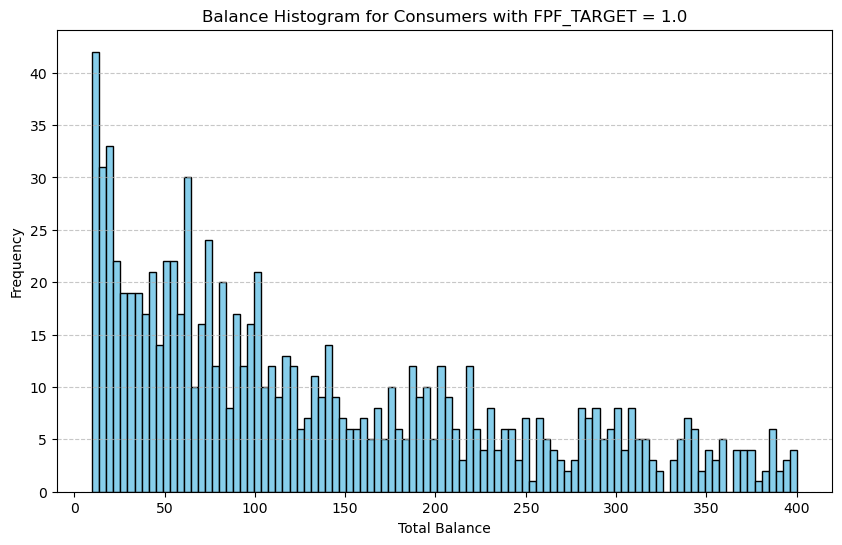

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter consumers with FPF_TARGET equal to 1.0
filtered_consumers = consumers[consumers['FPF_TARGET'] == 1.0]

# Plot balance histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_consumers['total_balance'], bins=100,range=(10,400),color='skyblue', edgecolor='black')
plt.title('Balance Histogram for Consumers with FPF_TARGET = 1.0')
plt.xlabel('Total Balance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


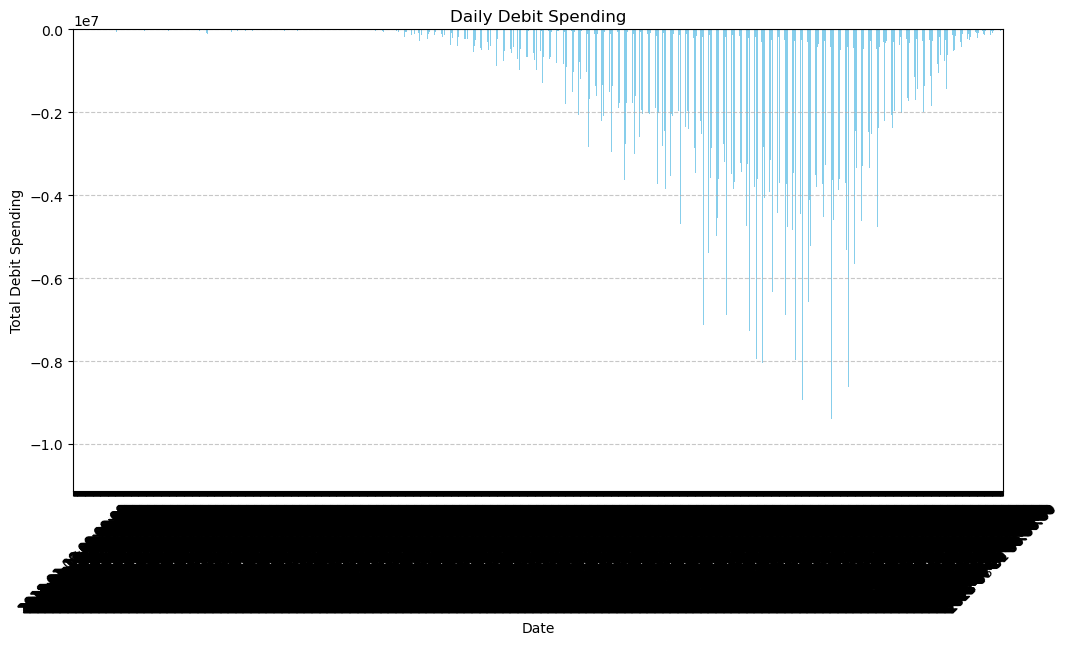

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
df = transactions
# Assuming df is your DataFrame containing transaction data
# Convert 'date' column to datetime format if not already
df['posted_date'] = pd.to_datetime(df['posted_date'])
df = df[df['amount'] < 0]

# Calculate total debit spending for each day
daily_spending = df.groupby('posted_date')['amount'].sum()

# Plot daily debit spending
plt.figure(figsize=(12, 6))
daily_spending.plot(kind='bar', color='skyblue')
plt.title('Daily Debit Spending')
plt.xlabel('Date')
plt.ylabel('Total Debit Spending')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### New Feature Engineering (consumer model instead of transaction model)

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [27]:
merged_df = merged_df.dropna()

In [28]:
# Convert 'posted_date' to datetime format
merged_df['posted_date'] = pd.to_datetime(merged_df['posted_date'])
merged_df['evaluation_date'] = pd.to_datetime(merged_df['evaluation_date'])
merged_df[['posted_date', 'evaluation_date']].info()

/var/folders/jc/kq3jtycs5yndcqlkj87_d8zm0000gn/T/ipykernel_9243/1513794225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['posted_date'] = pd.to_datetime(merged_df['posted_date'])
/var/folders/jc/kq3jtycs5yndcqlkj87_d8zm0000gn/T/ipykernel_9243/1513794225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['evaluation_date'] = pd.to_datetime(merged_df['evaluation_date'])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17737962 entries, 0 to 17738082
Data columns (total 2 columns):
 #   Column           Dtype         
---  ------           -----         
 0   posted_date      datetime64[ns]
 1   evaluation_date  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 406.0 MB


In [29]:
merged_df

,masked_consumer_id,posted_date,amount,category,evaluation_date,FPF_TARGET,total_balance,Product,posted_year
0,C02103629,2022-08-12,-21.000000,27.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
1,C02103629,2022-08-09,-8.600000,22.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
2,C02103629,2022-08-07,-30.049999,16.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
3,C02103629,2022-09-29,-0.460000,0.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
4,C02103629,2022-07-21,-50.000000,12.0,2022-11-16,1.0,109.529999,Payday Loans,2022.0
...,...,...,...,...,...,...,...,...,...
17738078,C04100784,2021-05-24,-84.959999,22.0,2022-03-31,1.0,2212.179932,Personal Loans,2021.0
17738079,C04100784,2021-05-24,-25.000000,15.0,2022-03-31,1.0,2212.179932,Personal Loans,2021.0
17738080,C04100784,2021-05-26,-1.000000,1.0,2022-03-31,1.0,2212.179932,Personal Loans,2021.0
17738081,C04100784,2021-05-26,-5.000000,1.0,2022-03-31,1.0,2212.179932,Personal Loans,2021.0


# Zichen Added Features

In [30]:
income_codes = list(transactions[transactions['amount'] > 0]['category'].unique())
spending_codes = list(transactions[transactions['amount'] < 0]['category'].unique())
loan_related_codes = [12, 32, 35, 36]#'LOAN','MORTGAGE', 'BNPL' (Buy Now Pay Later), 'AUTO_LOAN'

In [31]:
def get_yearly_related_feature(lst,category_name):
    #takes a list of category code and return a df which groupby the consumer id, year, and aggregate on sum and mean.
    df = merged_df[merged_df['category'].isin(lst)].groupby(["masked_consumer_id", "posted_year"]).agg(
        total_transactions = ('amount', sum),
        mean_transactions = ('amount', 'mean')
    )

    # Pivot the DataFrame to have one row per consumer with columns for each year
    df_pivot = df.reset_index().pivot(index='masked_consumer_id', columns='posted_year')
    print(df_pivot.columns)
    # Flatten the column names
    df_pivot.columns = [f'{category_name}_{year}_{agg}' for year, agg in df_pivot.columns]

    return df_pivot

paycheck_features = get_yearly_related_feature([3],"PAYCHECK")
paycheck_features.reset_index()

MultiIndex([('total_transactions', 2018.0),
            ('total_transactions', 2019.0),
            ('total_transactions', 2020.0),
            ('total_transactions', 2021.0),
            ('total_transactions', 2022.0),
            ('total_transactions', 2023.0),
            ( 'mean_transactions', 2018.0),
            ( 'mean_transactions', 2019.0),
            ( 'mean_transactions', 2020.0),
            ( 'mean_transactions', 2021.0),
            ( 'mean_transactions', 2022.0),
            ( 'mean_transactions', 2023.0)],
           names=[None, 'posted_year'])


,masked_consumer_id,PAYCHECK_total_transactions_2018.0,PAYCHECK_total_transactions_2019.0,PAYCHECK_total_transactions_2020.0,PAYCHECK_total_transactions_2021.0,PAYCHECK_total_transactions_2022.0,PAYCHECK_total_transactions_2023.0,PAYCHECK_mean_transactions_2018.0,PAYCHECK_mean_transactions_2019.0,PAYCHECK_mean_transactions_2020.0,PAYCHECK_mean_transactions_2021.0,PAYCHECK_mean_transactions_2022.0,PAYCHECK_mean_transactions_2023.0
0,C01100001,NaN,NaN,16018.389648,17658.919922,NaN,NaN,NaN,NaN,1456.217285,1765.891968,NaN,NaN
1,C01100002,NaN,NaN,NaN,25255.871094,921.390015,NaN,NaN,NaN,NaN,901.995361,307.130005,NaN
2,C01100003,NaN,NaN,48140.847656,9668.839844,NaN,NaN,NaN,NaN,1782.994385,1208.604980,NaN,NaN
3,C01100006,NaN,NaN,NaN,NaN,63976.058594,13483.580078,NaN,NaN,NaN,NaN,3046.479004,2696.716064
4,C01100010,NaN,NaN,NaN,29685.070312,13739.560547,NaN,NaN,NaN,NaN,593.701416,597.372192,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8586,C04104996,NaN,NaN,NaN,NaN,NaN,2802.870117,NaN,NaN,NaN,NaN,NaN,700.717529
8587,C04104997,NaN,NaN,NaN,NaN,32798.828125,11170.309570,NaN,NaN,NaN,NaN,3644.314453,2792.577393
8588,C04104998,NaN,NaN,NaN,NaN,69120.007812,22481.029297,NaN,NaN,NaN,NaN,3456.000488,3211.575684
8589,C04104999,NaN,NaN,NaN,NaN,7473.310059,3356.489990,NaN,NaN,NaN,NaN,467.081879,559.414978


In [32]:
income_related_features2 = get_yearly_related_feature(income_codes,"INCOME")
income_related_features2

MultiIndex([('total_transactions', 2018.0),
            ('total_transactions', 2019.0),
            ('total_transactions', 2020.0),
            ('total_transactions', 2021.0),
            ('total_transactions', 2022.0),
            ('total_transactions', 2023.0),
            ( 'mean_transactions', 2018.0),
            ( 'mean_transactions', 2019.0),
            ( 'mean_transactions', 2020.0),
            ( 'mean_transactions', 2021.0),
            ( 'mean_transactions', 2022.0),
            ( 'mean_transactions', 2023.0)],
           names=[None, 'posted_year'])


,INCOME_total_transactions_2018.0,INCOME_total_transactions_2019.0,INCOME_total_transactions_2020.0,INCOME_total_transactions_2021.0,INCOME_total_transactions_2022.0,INCOME_total_transactions_2023.0,INCOME_mean_transactions_2018.0,INCOME_mean_transactions_2019.0,INCOME_mean_transactions_2020.0,INCOME_mean_transactions_2021.0,INCOME_mean_transactions_2022.0,INCOME_mean_transactions_2023.0
masked_consumer_id,,,,,,,,,,,,
C01100001,NaN,NaN,50462.441406,71179.718750,NaN,NaN,NaN,NaN,212.027054,220.370651,NaN,NaN
C01100002,NaN,NaN,NaN,83581.234375,60656.781250,NaN,NaN,NaN,NaN,271.367645,187.791885,NaN
C01100003,NaN,NaN,63268.050781,10908.219727,NaN,NaN,NaN,NaN,645.592346,474.270416,NaN,NaN
C01100004,NaN,NaN,NaN,2071.520020,18567.089844,NaN,NaN,NaN,NaN,33.959343,46.534058,NaN
C01100005,NaN,NaN,12547.850586,197893.046875,NaN,NaN,NaN,NaN,65.695549,221.604752,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
C04104996,NaN,NaN,NaN,NaN,23335.740234,7293.550293,NaN,NaN,NaN,NaN,226.560593,214.516174
C04104997,NaN,NaN,NaN,NaN,29320.339844,8890.230469,NaN,NaN,NaN,NaN,137.010941,132.690002
C04104998,NaN,NaN,NaN,NaN,58021.898438,20621.570312,NaN,NaN,NaN,NaN,446.322296,327.326508


In [33]:
spending_related_feature = get_yearly_related_feature(spending_codes,"SPENDING")
spending_related_feature

MultiIndex([('total_transactions', 2018.0),
            ('total_transactions', 2019.0),
            ('total_transactions', 2020.0),
            ('total_transactions', 2021.0),
            ('total_transactions', 2022.0),
            ('total_transactions', 2023.0),
            ( 'mean_transactions', 2018.0),
            ( 'mean_transactions', 2019.0),
            ( 'mean_transactions', 2020.0),
            ( 'mean_transactions', 2021.0),
            ( 'mean_transactions', 2022.0),
            ( 'mean_transactions', 2023.0)],
           names=[None, 'posted_year'])


,SPENDING_total_transactions_2018.0,SPENDING_total_transactions_2019.0,SPENDING_total_transactions_2020.0,SPENDING_total_transactions_2021.0,SPENDING_total_transactions_2022.0,SPENDING_total_transactions_2023.0,SPENDING_mean_transactions_2018.0,SPENDING_mean_transactions_2019.0,SPENDING_mean_transactions_2020.0,SPENDING_mean_transactions_2021.0,SPENDING_mean_transactions_2022.0,SPENDING_mean_transactions_2023.0
masked_consumer_id,,,,,,,,,,,,
C01100001,NaN,NaN,-32713.759766,-63013.910156,NaN,NaN,NaN,NaN,-34.471825,-38.945557,NaN,NaN
C01100002,NaN,NaN,NaN,-72294.023438,-129785.171875,NaN,NaN,NaN,NaN,-74.761139,-98.247665,NaN
C01100003,NaN,NaN,-8112.990723,-1149.500244,NaN,NaN,NaN,NaN,-16.323925,-9.995655,NaN,NaN
C01100004,NaN,NaN,NaN,-10336.889648,-56477.410156,NaN,NaN,NaN,NaN,-67.561371,-66.365936,NaN
C01100005,NaN,NaN,-22191.750000,-210635.046875,NaN,NaN,NaN,NaN,-76.523277,-115.353256,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
C04104996,NaN,NaN,NaN,NaN,-26028.541016,-5388.580078,NaN,NaN,NaN,NaN,-49.483917,-26.942900
C04104997,NaN,NaN,NaN,NaN,-3892.319824,33.360023,NaN,NaN,NaN,NaN,-4.541797,0.121309
C04104998,NaN,NaN,NaN,NaN,-1814.389771,622.630066,NaN,NaN,NaN,NaN,-1.279541,1.568338


In [34]:
loan_related_feature = get_yearly_related_feature(loan_related_codes,"LOAN")
loan_related_feature

MultiIndex([('total_transactions', 2018.0),
            ('total_transactions', 2019.0),
            ('total_transactions', 2020.0),
            ('total_transactions', 2021.0),
            ('total_transactions', 2022.0),
            ('total_transactions', 2023.0),
            ( 'mean_transactions', 2018.0),
            ( 'mean_transactions', 2019.0),
            ( 'mean_transactions', 2020.0),
            ( 'mean_transactions', 2021.0),
            ( 'mean_transactions', 2022.0),
            ( 'mean_transactions', 2023.0)],
           names=[None, 'posted_year'])


,LOAN_total_transactions_2018.0,LOAN_total_transactions_2019.0,LOAN_total_transactions_2020.0,LOAN_total_transactions_2021.0,LOAN_total_transactions_2022.0,LOAN_total_transactions_2023.0,LOAN_mean_transactions_2018.0,LOAN_mean_transactions_2019.0,LOAN_mean_transactions_2020.0,LOAN_mean_transactions_2021.0,LOAN_mean_transactions_2022.0,LOAN_mean_transactions_2023.0
masked_consumer_id,,,,,,,,,,,,
C01100001,NaN,NaN,-1653.209961,-797.000000,NaN,NaN,NaN,NaN,-110.213997,-159.399994,NaN,NaN
C01100002,NaN,NaN,NaN,-18199.810547,-47807.058594,NaN,NaN,NaN,NaN,-758.325439,-1327.973877,NaN
C01100004,NaN,NaN,NaN,-1591.680054,-7923.920410,NaN,NaN,NaN,NaN,-795.840027,-720.356384,NaN
C01100005,NaN,NaN,NaN,-476.139984,NaN,NaN,NaN,NaN,NaN,-79.356667,NaN,NaN
C01100006,NaN,NaN,NaN,NaN,-14570.000000,-1250.000000,NaN,NaN,NaN,NaN,-809.444458,-625.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
C04104996,NaN,NaN,NaN,NaN,NaN,-25.129999,NaN,NaN,NaN,NaN,NaN,-25.129999
C04104997,NaN,NaN,NaN,NaN,-1006.520020,-841.200012,NaN,NaN,NaN,NaN,-77.424614,-76.472733
C04104998,NaN,NaN,NaN,NaN,-7817.140137,-2574.330078,NaN,NaN,NaN,NaN,-300.659241,-198.025391


In [35]:
consumer_features1 = merged_df.groupby('masked_consumer_id').agg(
    transactions_count=('masked_consumer_id', 'count'),
    max_debit_amount=('amount', lambda x: x[x < 0].max()),
    min_debit_amount=('amount', lambda x: x[x < 0].min()),
    average_debit_amount=('amount', lambda x: x[x < 0].mean()),
    max_credit_amount=('amount', lambda x: x[x > 0].max()),
    min_credit_amount=('amount', lambda x: x[x > 0].min()),
    average_credit_amount=('amount', lambda x: x[x > 0].mean()),
    count_of_credits=('amount', lambda x: x[x > 0].count()),
    count_of_debits=('amount', lambda x: x[x < 0].count()),
    #Zichen added feature
    
).reset_index()

# Fill NaN values with 0
consumer_features1.fillna(0, inplace=True)

# Display the first few rows to verify
consumer_features1.head()

,masked_consumer_id,transactions_count,max_debit_amount,min_debit_amount,average_debit_amount,max_credit_amount,min_credit_amount,average_credit_amount,count_of_credits,count_of_debits
0,C01100001,2658,-0.06,-8000.000000,-121.317741,8483.000000,0.01,896.001038,309,2349
1,C01100002,2489,-0.05,-19150.000000,-135.926132,20000.000000,0.01,904.673340,316,2173
2,C01100003,663,-0.99,-4310.279785,-148.625000,4409.399902,0.01,758.367188,111,552
3,C01100004,1084,-0.99,-1800.000000,-151.145477,1748.000000,0.01,402.589447,242,842
4,C01100005,2412,-0.60,-6987.069824,-218.482132,39915.160156,0.01,787.787781,514,1898


In [36]:
consumer_features2 = merged_df[['masked_consumer_id', 'FPF_TARGET', 'evaluation_date', 'total_balance']].drop_duplicates()
consumer_features2.head()

,masked_consumer_id,FPF_TARGET,evaluation_date,total_balance
0,C02103629,1.0,2022-11-16,109.529999
79,C02103630,0.0,2022-12-07,9.780000
567,C02103631,0.0,2022-11-30,-8.490000
1155,C02103632,0.0,2023-02-19,97.750000
1601,C02103633,1.0,2022-12-21,0.660000


In [37]:
# Calculate days span for each consumer
merged_df['days_span'] = (merged_df['evaluation_date'] - merged_df.groupby('masked_consumer_id')['posted_date'].transform('min')).dt.days.clip(lower=1)

# Calculate total debit and credit sums for each consumer
debit_credit_sums = merged_df.groupby('masked_consumer_id').apply(
    lambda df: pd.Series({
        'total_debit': df[df['amount'] < 0]['amount'].sum(),
        'total_credit': df[df['amount'] > 0]['amount'].sum(),
        'transaction_count': df['posted_date'].count(),
        'days_span': df['days_span'].iloc[0]
    })
)

# Calculate averages for debits, credits, and transaction frequency
debit_credit_sums['average_debit_spending'] = debit_credit_sums['total_debit'] / debit_credit_sums['days_span']
debit_credit_sums['average_credit_spending'] = debit_credit_sums['total_credit'] / debit_credit_sums['days_span']
debit_credit_sums['average_transaction_frequency'] = debit_credit_sums['transaction_count'] / debit_credit_sums['days_span']

# Calculate total amounts for specific categories
for code, cat in category_mapping.items():
    category_sum = merged_df[merged_df['category'] == code].groupby('masked_consumer_id')['amount'].sum()
    debit_credit_sums[f'total_{cat}'] = category_sum

# Calculate average amounts for specific categories
for cat in category_mapping.values():
    debit_credit_sums[f'average_{cat}'] = debit_credit_sums[f'total_{cat}'] / debit_credit_sums['days_span']

/var/folders/jc/kq3jtycs5yndcqlkj87_d8zm0000gn/T/ipykernel_9243/4059146898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['days_span'] = (merged_df['evaluation_date'] - merged_df.groupby('masked_consumer_id')['posted_date'].transform('min')).dt.days.clip(lower=1)


In [38]:
debit_credit_sums.fillna(0, inplace=True)
debit_credit_sums.reset_index(inplace=True)

In [39]:
debit_credit_sums.head(2)

,masked_consumer_id,total_debit,total_credit,transaction_count,days_span,average_debit_spending,average_credit_spending,average_transaction_frequency,total_SELF_TRANSFER,total_EXTERNAL_TRANSFER,...,average_HEALTHCARE_MEDICAL,average_PETS,average_EDUCATION,average_GIFTS_DONATIONS,average_BILLS_UTILITIES,average_MORTGAGE,average_CHILD_DEPENDENTS,average_RENT,average_BNPL,average_AUTO_LOAN
0,C01100001,-284975.6875,276864.25000,2658.0,364.0,-782.900240,760.616071,7.302198,135495.5625,-149038.515625,...,-8.700659,-7.965824,-0.027473,-0.023654,0.0,0.0,0.0,0.000000,0.0,0.0
1,C01100002,-295367.5000,285876.78125,2489.0,364.0,-811.449176,785.375773,6.837912,3150.0000,-13172.009766,...,-6.799917,0.000000,-0.100082,-0.195027,0.0,0.0,0.0,-0.193846,0.0,0.0


In [40]:
consumer_data = consumer_features1.merge(consumer_features2, on='masked_consumer_id')
consumer_data = consumer_data.merge(debit_credit_sums, on='masked_consumer_id')
consumer_data.head()

,masked_consumer_id,transactions_count,max_debit_amount,min_debit_amount,average_debit_amount,max_credit_amount,min_credit_amount,average_credit_amount,count_of_credits,count_of_debits,...,average_HEALTHCARE_MEDICAL,average_PETS,average_EDUCATION,average_GIFTS_DONATIONS,average_BILLS_UTILITIES,average_MORTGAGE,average_CHILD_DEPENDENTS,average_RENT,average_BNPL,average_AUTO_LOAN
0,C01100001,2658,-0.06,-8000.000000,-121.317741,8483.000000,0.01,896.001038,309,2349,...,-8.700659,-7.965824,-0.027473,-0.023654,0.0,0.0,0.0,0.000000,0.0,0.0
1,C01100002,2489,-0.05,-19150.000000,-135.926132,20000.000000,0.01,904.673340,316,2173,...,-6.799917,0.000000,-0.100082,-0.195027,0.0,0.0,0.0,-0.193846,0.0,0.0
2,C01100003,663,-0.99,-4310.279785,-148.625000,4409.399902,0.01,758.367188,111,552,...,-0.321291,-2.847088,0.000000,-0.260989,0.0,0.0,0.0,-50.588132,0.0,0.0
3,C01100004,1084,-0.99,-1800.000000,-151.145477,1748.000000,0.01,402.589447,242,842,...,-1.394337,-0.615497,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,C01100005,2412,-0.60,-6987.069824,-218.482132,39915.160156,0.01,787.787781,514,1898,...,-6.761432,-6.847741,-0.027548,-34.686472,0.0,0.0,0.0,-0.096419,0.0,0.0


In [41]:
# List all columns that start with 'total_'
cols_to_drop = [col for col in consumer_data.columns if col.startswith('total_')]

# Drop these columns from the DataFrame
consumer_data = consumer_data.drop(columns=cols_to_drop)

In [42]:
consumer_data

,masked_consumer_id,transactions_count,max_debit_amount,min_debit_amount,average_debit_amount,max_credit_amount,min_credit_amount,average_credit_amount,count_of_credits,count_of_debits,...,average_HEALTHCARE_MEDICAL,average_PETS,average_EDUCATION,average_GIFTS_DONATIONS,average_BILLS_UTILITIES,average_MORTGAGE,average_CHILD_DEPENDENTS,average_RENT,average_BNPL,average_AUTO_LOAN
0,C01100001,2658,-0.06,-8000.000000,-121.317741,8483.000000,0.01,896.001038,309,2349,...,-8.700659,-7.965824,-0.027473,-0.023654,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,C01100002,2489,-0.05,-19150.000000,-135.926132,20000.000000,0.01,904.673340,316,2173,...,-6.799917,0.000000,-0.100082,-0.195027,0.0,0.0,0.000000,-0.193846,0.000000,0.0
2,C01100003,663,-0.99,-4310.279785,-148.625000,4409.399902,0.01,758.367188,111,552,...,-0.321291,-2.847088,0.000000,-0.260989,0.0,0.0,0.000000,-50.588132,0.000000,0.0
3,C01100004,1084,-0.99,-1800.000000,-151.145477,1748.000000,0.01,402.589447,242,842,...,-1.394337,-0.615497,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,C01100005,2412,-0.60,-6987.069824,-218.482132,39915.160156,0.01,787.787781,514,1898,...,-6.761432,-6.847741,-0.027548,-34.686472,0.0,0.0,0.000000,-0.096419,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15874,C04104996,769,-0.04,-2944.860107,-59.678936,2000.000000,0.71,366.535461,93,676,...,-1.967660,-2.243454,-0.862396,-0.055710,0.0,0.0,0.000000,0.000000,0.000000,0.0
15875,C04104997,1163,-0.01,-1539.410034,-49.497822,4559.669922,1.65,641.728943,86,1077,...,-1.768022,-1.426434,-0.059861,-1.793315,0.0,0.0,-0.398162,0.000000,-0.156657,0.0
15876,C04104998,1833,-0.26,-1000.000000,-54.445499,6199.200195,8.09,1353.600098,72,1761,...,-5.414067,-1.264206,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
15877,C04104999,1493,-1.00,-25000.000000,-353.783508,25000.000000,1.00,1909.822388,225,1268,...,-0.636713,0.000000,-0.250696,0.000000,0.0,0.0,0.000000,-0.837047,0.000000,0.0


In [43]:
consumer_data.columns

Index(['masked_consumer_id', 'transactions_count', 'max_debit_amount',
       'min_debit_amount', 'average_debit_amount', 'max_credit_amount',
       'min_credit_amount', 'average_credit_amount', 'count_of_credits',
       'count_of_debits', 'FPF_TARGET', 'evaluation_date', 'transaction_count',
       'days_span', 'average_debit_spending', 'average_credit_spending',
       'average_transaction_frequency', 'average_SELF_TRANSFER',
       'average_EXTERNAL_TRANSFER', 'average_DEPOSIT', 'average_PAYCHECK',
       'average_MISCELLANEOUS', 'average_PAYCHECK_PLACEHOLDER',
       'average_REFUND', 'average_INVESTMENT_INCOME', 'average_OTHER_BENEFITS',
       'average_UNEMPLOYMENT_BENEFITS', 'average_SMALL_DOLLAR_ADVANCE',
       'average_TAX', 'average_LOAN', 'average_INSURANCE',
       'average_FOOD_AND_BEVERAGES', 'average_UNCATEGORIZED',
       'average_GENERAL_MERCHANDISE', 'average_AUTOMOTIVE',
       'average_GROCERIES', 'average_ATM_CASH', 'average_ENTERTAINMENT',
       'average_TRAVE

In [44]:
working_data = consumer_data.copy()

In [45]:
# working_data['credit_to_debit_ratio'] = working_data['average_credit_amount'] / working_data['average_debit_amount'].abs()
working_data['investment_to_income_ratio'] = working_data['average_INVESTMENT_INCOME'] / (working_data['average_PAYCHECK'] + 1e-5)  # Adding a small number to avoid division by zero
working_data['debit_volatility'] = working_data.groupby('masked_consumer_id')['average_debit_amount'].transform(np.std)
working_data['credit_volatility'] = working_data.groupby('masked_consumer_id')['average_credit_amount'].transform(np.std)
working_data['max_min_debit_ratio'] = working_data['max_debit_amount'] / (working_data['min_debit_amount'].abs() + 1e-5)  # To avoid division by zero
working_data['high_cost_debit_flag'] = (working_data['max_debit_amount'] < -5000).astype(int)  # High cost debit transaction
working_data['low_cost_credit_flag'] = (working_data['min_credit_amount'] < 100).astype(int)  # Low cost credit transaction
working_data['transactions_per_day'] = working_data['transactions_count'] / working_data['days_span']
working_data['cumulative_credits'] = working_data.groupby('masked_consumer_id')['average_credit_amount'].cumsum()
working_data['cumulative_debits'] = working_data.groupby('masked_consumer_id')['average_debit_amount'].cumsum()
working_data['has_education_transactions'] = (working_data['average_EDUCATION'] != 0).astype(int)

In [46]:
working_data['log_max_credit'] = np.log(working_data['max_credit_amount'] + 1)  # Log of max credit amount to reduce skewness
working_data['log_max_debit'] = np.log(working_data['max_debit_amount'].abs() + 1)  # Log of absolute max debit amount to reduce skewness
working_data['extreme_healthcare_spending'] = (working_data['average_HEALTHCARE_MEDICAL'] < -100).astype(int)
working_data['extreme_education_spending'] = (working_data['average_EDUCATION'] < -100).astype(int)
working_data['proportion_credits'] = working_data['count_of_credits'] / working_data['transactions_count']
working_data['proportion_debits'] = working_data['count_of_debits'] / working_data['transactions_count']
# Standard deviation of transaction amounts as an indicator of financial stability
working_data['std_transaction_amount'] = working_data[['average_debit_amount', 'average_credit_amount']].std(axis=1)
# Ratio of total credits to total debits to indicate spending efficiency
working_data['spending_efficiency'] = working_data['average_credit_amount'] / (working_data['average_debit_amount'].abs() + 1e-5)
# Assuming 'evaluation_date' is in YYYY-MM-DD format and you want to capture seasonal effects
working_data['month'] = pd.to_datetime(working_data['evaluation_date']).dt.month
working_data['is_high_spending_season'] = working_data['month'].isin([11, 12]).astype(int)  # Nov and Dec as high spending months
# Measure variability in transaction frequency to assess stability
working_data['frequency_stability'] = working_data.groupby('masked_consumer_id')['transactions_per_day'].transform(np.std)
# Flags for unusual spending or income patterns
working_data['high_credit_frequency'] = (working_data['count_of_credits'] > working_data['count_of_credits'].quantile(0.95)).astype(int)
working_data['low_debit_frequency'] = (working_data['count_of_debits'] < working_data['count_of_debits'].quantile(0.05)).astype(int)

In [47]:
working_data2 = working_data.copy()

In [48]:
# working_data2['CLV'] = working_data2.groupby('masked_consumer_id').cumsum()['average_credit_amount'] - working_data2.groupby('masked_consumer_id').cumsum()['average_debit_amount']
# Create rolling averages for credits and debits to capture trends over time
working_data2.sort_values(by=['masked_consumer_id', 'evaluation_date'], inplace=True)  # Ensure data is sorted
working_data2['rolling_avg_credits'] = working_data2.groupby('masked_consumer_id')['average_credit_amount'].rolling(window=12, min_periods=1).mean().reset_index(level=0, drop=True)
working_data2['rolling_avg_debits'] = working_data2.groupby('masked_consumer_id')['average_debit_amount'].rolling(window=12, min_periods=1).mean().reset_index(level=0, drop=True)
# Extract day of week from date and create dummy variables for weekdays
working_data2['day_of_week'] = pd.to_datetime(working_data2['evaluation_date']).dt.dayofweek
working_data2 = pd.get_dummies(working_data2, columns=['day_of_week'], prefix='dow')
# Create an interaction term between credits and debits to explore their combined effect on the target variable
working_data2['credit_debit_interaction'] = working_data2['average_credit_amount'] * working_data2['average_debit_amount']
# Create lag features for credit and debit amounts to capture previous transaction values
working_data2['lag1_credit'] = working_data2.groupby('masked_consumer_id')['average_credit_amount'].shift(1)
working_data2['lag1_debit'] = working_data2.groupby('masked_consumer_id')['average_debit_amount'].shift(1)
# Calculate the percentage change from the previous record to capture growth or contraction
working_data2['pct_change_credit'] = working_data2.groupby('masked_consumer_id')['average_credit_amount'].pct_change()
working_data2['pct_change_debit'] = working_data2.groupby('masked_consumer_id')['average_debit_amount'].pct_change()
# Flags to identify unusually high or low transactions
working_data2['extreme_high_credit'] = (working_data2['average_credit_amount'] > working_data2['average_credit_amount'].quantile(0.99)).astype(int)
working_data2['extreme_low_debit'] = (working_data2['average_debit_amount'] < working_data2['average_debit_amount'].quantile(0.01)).astype(int)


In [49]:
working_data2.evaluation_date

0       2021-08-26
1       2022-08-02
2       2021-03-04
3       2022-11-19
4       2021-11-21
           ...    
15874   2023-03-31
15875   2023-03-31
15876   2023-03-31
15877   2023-03-31
15878   2023-03-31
Name: evaluation_date, Length: 15879, dtype: datetime64[ns]

In [50]:
import pandas as pd
import numpy as np

# Generate date range for the year
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# Initialize spending column with False
spending = np.full(len(dates), False)

# Holidays
holidays = [
    '2021-01-01',  # New Year's Day (2021)
    '2021-02-14',  # Valentine's Day (2021)
    '2021-05-09',  # Mother's Day (2021)
    '2021-06-20',  # Father's Day (2021)
    '2021-11-25',  # Thanksgiving (2021)
    '2021-12-25',  # Christmas (2021)
    '2021-12-31',  # New Year's Eve (2021)
    '2022-01-01',  # New Year's Day (2022)
    '2022-02-14',  # Valentine's Day (2022)
    '2022-05-08',  # Mother's Day (2022)
    '2022-06-19',  # Father's Day (2022)
    '2022-11-24',  # Thanksgiving (2022)
    '2022-12-25',  # Christmas (2022)
    '2022-12-31',  # New Year's Eve (2022)
    '2023-01-01',  # New Year's Day (2023)
    '2023-02-14',  # Valentine's Day (2023)
    '2023-05-14',  # Mother's Day (2023)
    '2023-06-18',  # Father's Day (2023)
    '2023-11-23',  # Thanksgiving (2023)
    '2023-12-25',  # Christmas (2023)
    '2023-12-31'   # New Year's Eve (2023)
]

for holiday in holidays:
    spending[dates == holiday] = True  # Debit spending on holidays

# Sales and Promotions (e.g., Black Friday, Cyber Monday)
sales_promotions = [
    '2021-11-26',  # Black Friday (2021)
    '2021-11-29',  # Cyber Monday (2021)
    '2021-07-15',  # Amazon Prime Day (2021)
    '2021-09-06',  # Labor Day Sales (2021)
    '2021-05-31',  # Memorial Day Sales (2021)
    '2021-08-15',  # Back-to-School Sales (2021)
    '2021-07-04',  # Independence Day Sales (2021)
    '2021-02-15',  # President's Day Sales (2021)
    '2022-11-25',  # Black Friday (2022)
    '2022-11-28',  # Cyber Monday (2022)
    '2022-07-15',  # Amazon Prime Day (2022)
    '2022-09-05',  # Labor Day Sales (2022)
    '2022-05-30',  # Memorial Day Sales (2022)
    '2022-08-15',  # Back-to-School Sales (2022)
    '2022-07-04',  # Independence Day Sales (2022)
    '2022-02-21'   # President's Day Sales (2022)
    '2023-11-24',  # Black Friday (2023)
    '2023-11-27',  # Cyber Monday (2023)
    '2023-07-15',  # Amazon Prime Day (2023)
    '2023-09-04',  # Labor Day Sales (2023)
    '2023-05-29',  # Memorial Day Sales (2023)
    '2023-08-15',  # Back-to-School Sales (2023)
    '2023-07-04',  # Independence Day Sales (2023)
    '2023-02-20',  # President's Day Sales (2023)
]
for event in sales_promotions:
    spending[dates == event] = True  # Debit spending on sales and promotions

# Create DataFrame
df = pd.DataFrame({'Date': dates, 'Spending': spending})
df.head()


,Date,Spending
0,2023-01-01,True
1,2023-01-02,False
2,2023-01-03,False
3,2023-01-04,False
4,2023-01-05,False


In [51]:
for f in [loan_related_feature,spending_related_feature,income_related_features2,paycheck_features]:
    working_data2 = pd.merge(working_data2,f,left_on="masked_consumer_id",right_on="masked_consumer_id",how='left')

In [52]:
spx500 = working_data2.copy()

In [53]:
spx_data = pd.read_csv('spx_Data.csv')
spx_data['Date'] = pd.to_datetime(spx_data['Date'])
spx_data = pd.merge(spx_data, df, left_on='Date', right_on='Date', how='left')
spx_data.head()

,Date,Open,High,Low,Close,Spending
0,2023-03-31,"4,056.18","4,110.75","4,056.18","4,109.31",False
1,2023-03-30,"4,046.74","4,057.85","4,032.10","4,050.83",False
2,2023-03-29,"3,999.53","4,030.59","3,999.53","4,027.81",False
3,2023-03-28,"3,974.13","3,979.20","3,951.53","3,971.27",False
4,2023-03-27,"3,982.93","4,003.83","3,970.49","3,977.53",False


In [54]:
spx500['evaluation_date'] = pd.to_datetime(spx500['evaluation_date'])
spx_data['Date'] = pd.to_datetime(spx_data['Date'])
spx_data['Open'] = spx_data['Open'].str.replace(',', '').astype(float)
spx_data['High'] = spx_data['High'].str.replace(',', '').astype(float)
spx_data['Low'] = spx_data['Low'].str.replace(',', '').astype(float)
spx_data['Close'] = spx_data['Close'].str.replace(',', '').astype(float)

In [55]:
spx500 = spx500.merge(spx_data, how='left', left_on='evaluation_date', right_on='Date')
spx500.drop('Date', axis=1, inplace=True)

In [56]:
spx500

,masked_consumer_id,transactions_count,max_debit_amount,min_debit_amount,average_debit_amount,max_credit_amount,min_credit_amount,average_credit_amount,count_of_credits,count_of_debits,...,PAYCHECK_mean_transactions_2019.0,PAYCHECK_mean_transactions_2020.0,PAYCHECK_mean_transactions_2021.0,PAYCHECK_mean_transactions_2022.0,PAYCHECK_mean_transactions_2023.0,Open,High,Low,Close,Spending
0,C01100001,2658,-0.06,-8000.000000,-121.317741,8483.000000,0.01,896.001038,309,2349,...,NaN,1456.217285,1765.891968,NaN,NaN,4493.75,4495.90,4468.99,4470.00,NaN
1,C01100002,2489,-0.05,-19150.000000,-135.926132,20000.000000,0.01,904.673340,316,2173,...,NaN,NaN,901.995361,307.130005,NaN,4104.21,4140.47,4079.81,4091.19,NaN
2,C01100003,663,-0.99,-4310.279785,-148.625000,4409.399902,0.01,758.367188,111,552,...,NaN,1782.994385,1208.604980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C01100004,1084,-0.99,-1800.000000,-151.145477,1748.000000,0.01,402.589447,242,842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C01100005,2412,-0.60,-6987.069824,-218.482132,39915.160156,0.01,787.787781,514,1898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15874,C04104996,769,-0.04,-2944.860107,-59.678936,2000.000000,0.71,366.535461,93,676,...,NaN,NaN,NaN,NaN,700.717529,4056.18,4110.75,4056.18,4109.31,False
15875,C04104997,1163,-0.01,-1539.410034,-49.497822,4559.669922,1.65,641.728943,86,1077,...,NaN,NaN,NaN,3644.314453,2792.577393,4056.18,4110.75,4056.18,4109.31,False
15876,C04104998,1833,-0.26,-1000.000000,-54.445499,6199.200195,8.09,1353.600098,72,1761,...,NaN,NaN,NaN,3456.000488,3211.575684,4056.18,4110.75,4056.18,4109.31,False
15877,C04104999,1493,-1.00,-25000.000000,-353.783508,25000.000000,1.00,1909.822388,225,1268,...,NaN,NaN,NaN,467.081879,559.414978,4056.18,4110.75,4056.18,4109.31,False


In [57]:
spx500['spx_daily_range'] = spx500['High'] - spx500['Low']
# Calculate the daily market movement direction (1 if closing higher than opening, 0 otherwise)
spx500['spx_market_up'] = (spx500['Close'] > spx500['Open']).astype(int)
# Use a simple moving average of the closing prices to gauge market momentum
spx500['spx_30d_avg_close'] = spx500['Close'].rolling(window=30, min_periods=1).mean()
# Calculate the daily return percentage of the S&P 500
spx500['spx_daily_return'] = (spx500['Close'] - spx500['Open']) / spx500['Open']
# Create lagged features of the market data to explore potential delayed effects
spx500['spx_lag1_close'] = spx500['Close'].shift(1)
spx500['spx_lag5_close'] = spx500['Close'].shift(5)
# Use exponential moving average of daily range to understand short-term volatility trends
spx500['spx_ema_volatility'] = spx500['spx_daily_range'].ewm(span=10, adjust=False).mean()

In [58]:
spx500['relative_market_performance'] = spx500['spx_daily_return'] - spx500['spending_efficiency']
# Adjust the market's open to close movement by the range to get a normalized market movement score
spx500['normalized_market_movement'] = (spx500['Close'] - spx500['Open']) / spx500['spx_daily_range'].replace(0, 0.01)
# Create an index that might indicate financial stress based on market volatility and personal spending
spx500['financial_stress_index'] = spx500['spx_ema_volatility'] * spx500['average_debit_amount']
# Interaction term between market return and average spending categories
spx500['market_impact_on_healthcare'] = spx500['spx_daily_return'] * spx500['average_HEALTHCARE_MEDICAL']
spx500['market_impact_on_education'] = spx500['spx_daily_return'] * spx500['average_EDUCATION']
# Simulate a simplified version of the CAPE ratio using a rolling mean of Close prices over the past 12 months and current earnings
spx500['spx_rolling_mean_close'] = spx500['Close'].rolling(window=252, min_periods=10).mean()  # Approx. 252 trading days in a year
spx500['simple_cape_ratio'] = spx500['Close'] / spx500['spx_rolling_mean_close']
# Calculate returns over various periods to understand longer-term market trends
spx500['spx_return_5day'] = (spx500['Close'] / spx500['Close'].shift(5) - 1).fillna(0)
spx500['spx_return_30day'] = (spx500['Close'] / spx500['Close'].shift(30) - 1).fillna(0)
# Use forward and backward shifts to create features that might predict or result from market movements
spx500['spx_lead_5day'] = spx500['Close'].shift(-5)  # Looking 5 days into the future
spx500['spx_lag_5day'] = spx500['Close'].shift(5)   # Looking 5 days into the past
# Examine how market volatility might influence the frequency of consumer transactions
spx500['volatility_transaction_interaction'] = spx500['spx_ema_volatility'] * spx500['transactions_count']

In [59]:
spx500.columns

Index(['masked_consumer_id', 'transactions_count', 'max_debit_amount',
       'min_debit_amount', 'average_debit_amount', 'max_credit_amount',
       'min_credit_amount', 'average_credit_amount', 'count_of_credits',
       'count_of_debits',
       ...
       'financial_stress_index', 'market_impact_on_healthcare',
       'market_impact_on_education', 'spx_rolling_mean_close',
       'simple_cape_ratio', 'spx_return_5day', 'spx_return_30day',
       'spx_lead_5day', 'spx_lag_5day', 'volatility_transaction_interaction'],
      dtype='object', length=165)

In [60]:
# Replace infinity values with NaN
spx500 = spx500.replace([np.inf, -np.inf, np.nan], 0)
spx500['Spending'] = pd.to_numeric(spx500['Spending'], errors='coerce')



# Split data into features and target
X = spx500.drop(columns=['evaluation_date', 'masked_consumer_id', 'FPF_TARGET'])
y = spx500['FPF_TARGET']




scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
lr = LogisticRegression()

# Perform k-fold cross-validation
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')

# Fit the model on the entire training set
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean Cross-Validation ROC-AUC Score:", np.mean(cv_scores))
print("Test Accuracy:", accuracy)
print("Test ROC-AUC Score:", roc_auc)

/Users/Wally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Wally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Cross-Validation ROC-AUC Scores: [0.81679068 0.81825552 0.81382054 0.79807747 0.81784313]
Mean Cross-Validation ROC-AUC Score: 0.8129574676431932
Test Accuracy: 0.8438287153652393
Test ROC-AUC Score: 0.8145191381800675


/Users/Wally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
X_train

,transactions_count,max_debit_amount,min_debit_amount,average_debit_amount,max_credit_amount,min_credit_amount,average_credit_amount,count_of_credits,count_of_debits,transaction_count,...,financial_stress_index,market_impact_on_healthcare,market_impact_on_education,spx_rolling_mean_close,simple_cape_ratio,spx_return_5day,spx_return_30day,spx_lead_5day,spx_lag_5day,volatility_transaction_interaction
4870,819,-0.02,-704.929993,-60.421383,2110.500000,0.01,148.106125,238,581,819.0,...,-3209.048245,-0.000797,0.000000,3949.246174,1.025722,0.000000,0.023250,0.00,0.00,43498.019841
447,2119,-0.50,-25000.000000,-129.234528,34771.000000,0.01,1972.093506,137,1982,2119.0,...,-10523.024119,0.000000,0.000000,4111.180129,0.000000,0.000000,0.000000,4709.85,0.00,172541.259090
1791,503,-0.05,-5000.000000,-96.016922,5000.000000,0.02,917.103638,34,469,503.0,...,-6770.801216,0.000000,0.000000,4139.853117,0.000000,0.000000,0.000000,4288.70,0.00,35469.924894
4963,415,-0.02,-600.000000,-65.125366,1952.410034,0.01,224.172897,93,322,415.0,...,-3792.504286,0.000000,0.000000,3960.972105,0.000000,0.000000,0.000000,0.00,0.00,24167.069918
7745,798,-0.10,-1600.000000,-58.372433,1390.930054,0.01,373.533661,107,691,798.0,...,-3326.966493,-0.000084,-0.024760,3942.907500,0.976254,-0.024649,0.000000,0.00,3946.56,45482.415898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13418,2664,-0.42,-12000.000000,-52.771824,14156.459961,0.01,644.862183,210,2454,2664.0,...,-2963.156230,0.017697,0.007713,3965.145438,1.044113,0.000000,-0.001238,4122.47,0.00,149584.524757
5390,907,-0.07,-2944.449951,-66.222122,2975.780029,0.01,255.619080,188,719,907.0,...,-4300.143044,0.000000,0.000000,3934.347658,0.000000,0.000000,0.000000,3852.97,3759.69,58896.175656
860,287,-0.96,-1252.530029,-149.185287,1901.000000,0.01,763.940613,45,237,287.0,...,-8659.188819,0.007151,-0.000000,4071.337315,1.004685,-0.122766,0.000000,0.00,4662.85,16658.393284
15795,1205,-0.35,-3782.899902,-75.901993,4392.259766,1.00,807.639404,103,1102,1205.0,...,-4944.929015,0.000000,0.000000,3952.796197,0.000000,0.000000,0.000000,0.00,3970.99,78504.387612


In [68]:
X_train['Spending']

4870     0
447      0
1791     0
4963     0
7745     0
        ..
13418    0
5390     0
860      0
15795    0
7270     0
Name: Spending, Length: 12703, dtype: int64

In [71]:
import xgboost as xgb

# Create the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, seed=42, use_label_encoder=False)

# Train the model
model.fit(X_train, y_train, eval_metric='logloss', verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [72]:
y_pred_train = model.predict(X_train)
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", train_accuracy)

train_auc_score = roc_auc_score(y_train, y_pred_proba_train)
print("AUC Score:", train_auc_score)

Accuracy: 1.0
AUC Score: 1.0


In [73]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

Accuracy: 0.8866498740554156
AUC Score: 0.8967741935483872


In [74]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[2526  154]
 [ 206  290]]


In [75]:
from sklearn.model_selection import GridSearchCV
import warnings
parameters = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}
warnings.filterwarnings("ignore", category=UserWarning, message="`eval_metric` in `fit` method is deprecated")
grid_search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False),
                           parameters, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train, eval_metric='logloss')

print("Best parameters:", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score:  0.9079469857497177


In [76]:
best_params = grid_search.best_params_
model = xgb.XGBClassifier(**best_params, objective='binary:logistic', use_label_encoder=False)

model.fit(X_train, y_train, eval_metric='logloss')

cv_scores_accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy')
cv_scores_roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Average Accuracy:", cv_scores_accuracy.mean())

print("Cross-Validation ROC-AUC Scores:", cv_scores_roc_auc)
print("Average ROC-AUC:", cv_scores_roc_auc.mean())


Cross-Validation Accuracy Scores: [0.91309824 0.73173804 0.78809824 0.6993073  0.86929134]
Average Accuracy: 0.8003066304369385
Cross-Validation ROC-AUC Scores: [0.95543545 0.87860749 0.83941045 0.71366908 0.6379784 ]
Average ROC-AUC: 0.8050201722615189


In [75]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Perform k-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

# Fit the model on the entire training set
model.fit(X_train, y_train, eval_metric='logloss')

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean Cross-Validation ROC-AUC Score:", np.mean(cv_scores))

Cross-Validation ROC-AUC Scores: [0.90681119 0.9209338  0.90245142 0.89681669 0.91263349]
Mean Cross-Validation ROC-AUC Score: 0.9079293168575848


In [7]:
pip show lightgbm


Name: lightgbm
Version: 4.3.0
Summary: LightGBM Python Package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (MIT)
        
        Copyright (c) Microsoft Corporation
        
        Permission is hereby granted, free of charge, to any person obtaining a copy
        of this software and associated documentation files (the "Software"), to deal
        in the Software without restriction, including without limitation the rights
        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
        copies of the Software, and to permit persons to whom the Software is
        furnished to do so, subject to the following conditions:
        
        The above copyright notice and this permission notice shall be included in all
        copies or substantial portions of the Software.
        
        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
        IMPLIED, INCLUDING BUT NOT LIMITED TO 

In [78]:
from lightgbm import LGBMClassifier


OSError: dlopen(/Users/Wally/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <C3EB28DD-60B6-3334-AFA2-72BBBF9DBAEF> /Users/Wally/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [79]:
from lightgbm import LGBMClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

clf = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)

# Train the model
clf.fit(X_train, y_train)

# Make predictions for ROC curve
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, clf.predict(X_test))
conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
report = classification_report(y_test, clf.predict(X_test))
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)
print("ROC-AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, marker='.', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

OSError: dlopen(/Users/Wally/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <C3EB28DD-60B6-3334-AFA2-72BBBF9DBAEF> /Users/Wally/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [2]:
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initialize the LGBMClassifier with your desired parameters
clf = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)

# Train the model with early stopping
clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],  # Assuming you have a validation set
    early_stopping_rounds=50,
    eval_metric='logloss',  # Evaluation metric can be 'logloss', 'auc', etc.
    callbacks=[early_stopping(50)]
)

# Make predictions for ROC curve
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, clf.predict(X_test))
conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
report = classification_report(y_test, clf.predict(X_test))
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)
print("ROC-AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, marker='.', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

# Find the most important features
importances = clf.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print the most important features
print("Feature Importances:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")

# Trim the least important features
# You can choose the number of top features to keep, for example, top 10 features
top_features = [feature for feature, importance in feature_importances[:10]]
X_train_trimmed = X_train[top_features]
X_test_trimmed = X_test[top_features]

# Train the model again with the trimmed features
clf.fit(
    X_train_trimmed, y_train,
    eval_set=[(X_valid[top_features], y_valid)],  # Assuming you have a validation set
    early_stopping_rounds=50,
    eval_metric='logloss',
    callbacks=[early_stopping(50)]
)

# Evaluate the model again with the trimmed features
y_pred_proba_trimmed = clf.predict_proba(X_test_trimmed)[:, 1]
accuracy_trimmed = accuracy_score(y_test, clf.predict(X_test_trimmed))
roc_auc_trimmed = roc_auc_score(y_test, y_pred_proba_trimmed)

print("Accuracy with Trimmed Features:", accuracy_trimmed)
print("ROC-AUC Score with Trimmed Features:", roc_auc_trimmed)


OSError: dlopen(/Users/Wally/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <C3EB28DD-60B6-3334-AFA2-72BBBF9DBAEF> /Users/Wally/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 400],  # Example: explore around your initial choice
    'learning_rate': [0.01, 0.1, 0.2],  # Smaller steps might provide better accuracy
    'max_depth': [3, 6, -1]  # Explore depths: a small depth, a medium depth, and unlimited
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',  # Focus on ROC AUC
    cv=3  # Number of cross-validation folds
)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best AUC score from Grid Search:", grid_search.best_score_)

In [67]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("AUC:", auc)

Accuracy: 0.8954659949622166
AUC: 0.9018265527202696


In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Assuming X and y are your features and target variable
clf = HistGradientBoostingClassifier()
cv_scores_accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
cv_scores_auc = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Average Accuracy:", cv_scores_accuracy.mean())

print("Cross-Validation AUC Scores:", cv_scores_auc)
print("Average AUC:", cv_scores_auc.mean())


Cross-Validation Accuracy Scores: [0.91120907 0.72827456 0.8324937  0.70938287 0.86897638]
Average Accuracy: 0.8100673158928181
Cross-Validation AUC Scores: [0.95438413 0.87609902 0.8180031  0.73443653 0.58043972]
Average AUC: 0.7926724991436307


Accuracy: 0.8948362720403022
Confusion Matrix:
 [[2536  144]
 [ 190  306]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      2680
         1.0       0.68      0.62      0.65       496

    accuracy                           0.89      3176
   macro avg       0.81      0.78      0.79      3176
weighted avg       0.89      0.89      0.89      3176

ROC-AUC Score: 0.8989069270582571


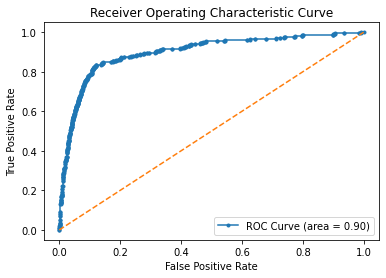

In [51]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # probabilities for the positive class

# Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Output results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)
print("ROC-AUC Score:", roc_auc)

# Optionally, plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, marker='.', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()